# 1- Importing the necessary libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Wind_data.csv')
df = pd. DataFrame(dataset)
df.head()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
0,8/7/2019 0:00,0.652524,10.35,8.99,4.57,9.69,8.90,2.90,5.74,1.16,...,11.12,6.79,9.31,11.63,10.72,10.55,11.41,10.77,10.17,9.24
1,8/7/2019 1:00,0.605852,9.70,8.28,5.78,9.10,7.98,2.23,3.46,0.97,...,10.47,6.40,9.50,11.10,11.02,9.91,11.16,10.98,10.16,9.09
2,8/7/2019 2:00,0.564094,9.04,7.39,6.21,8.98,7.78,1.98,2.62,0.92,...,10.10,6.23,9.46,10.74,11.19,9.52,11.00,11.10,10.04,9.04
3,8/7/2019 3:00,0.532721,8.78,7.49,6.43,8.84,7.82,1.33,2.43,0.68,...,9.67,6.01,9.45,10.65,11.27,9.11,10.93,11.18,10.20,8.89
4,8/7/2019 4:00,0.495608,8.23,6.88,6.81,8.52,6.65,1.64,2.45,0.59,...,9.24,5.83,9.30,9.78,10.85,8.64,10.69,10.83,9.88,8.67


# 2- Data cleaning

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 114 entries, DATETIME to WS_921049
dtypes: float64(113), object(1)
memory usage: 3.2+ MB
None


#### Dataset does not have "None" value, however we check that again.

In [4]:
print(sum(df.duplicated()))

0


#### No Duplicated rows

In [5]:
print(sum(df.isnull().sum()))

# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# imputer.fit(df[df.columns[1:-1]])
# df[df.columns[1:-1]] = imputer.transform(df[df.columns[1:-1]])

0


#### No "None" value. In case, we can use the provided code

### 2-1 Chronological Order and Equidistant Timestamps

In [6]:
from datetime import datetime, date , timedelta

df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%m/%d/%Y %H:%M')
df = df.sort_values(by='DATETIME')

# Check time intervals
df['delta'] = df['DATETIME'] - df['DATETIME'].shift(1)
df['delta'].iloc[0] = timedelta(hours=1)
df[['DATETIME', 'delta']].head()

,DATETIME,delta
0,2019-08-07 00:00:00,0 days 01:00:00
1,2019-08-07 01:00:00,0 days 01:00:00
2,2019-08-07 02:00:00,0 days 01:00:00
3,2019-08-07 03:00:00,0 days 01:00:00
4,2019-08-07 04:00:00,0 days 01:00:00


In [7]:
df['delta'].sum(), df['delta'].count()

(Timedelta('154 days 00:00:00'), 3635)

#### 154 days equal to 3696 hours (timesteps) It is obvious some hours are missed because we have 3635 timesteps!

In [8]:
# Create a DataFrame with all expected timestamps
start_date = '2019-08-07 00:00'  # Assuming this is your start date
end_date = pd.date_range(start=start_date, periods=154*24, freq='H')
expected_df = pd.DataFrame({'DATETIME': end_date})

# Load your actual DataFrame
# Replace this with your actual DataFrame loading code
# df = pd.read_csv('your_data.csv')

# Convert 'DATETIME' column to datetime if it's not already in datetime format
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Merge the expected DataFrame with your actual DataFrame
merged_df = pd.merge(expected_df, df, on='DATETIME', how='left')

# Find missing timestamps
missing_timestamps = merged_df[merged_df.isnull().any(axis=1)]

print("Missing timestamps:")
print(missing_timestamps['DATETIME'])


Missing timestamps:
5      2019-08-07 05:00:00
18     2019-08-07 18:00:00
45     2019-08-08 21:00:00
47     2019-08-08 23:00:00
72     2019-08-10 00:00:00
               ...        
3651   2020-01-06 03:00:00
3652   2020-01-06 04:00:00
3653   2020-01-06 05:00:00
3654   2020-01-06 06:00:00
3655   2020-01-06 07:00:00
Name: DATETIME, Length: 61, dtype: datetime64[ns]


#### the 61 missed steps found!

# 3- Feature selection

In [9]:
df.corr()
corr_matrix = df.corr()
cor_target=abs(corr_matrix["CF"]).sort_values(ascending=False)
cor_target

CF            1.000000
WS_2503597    0.848757
WS_2508550    0.841939
WS_2508545    0.840002
WS_75936      0.839991
                ...   
WS_2385763    0.167350
WS_2113254    0.151538
WS_1681085    0.072676
WS_1625374    0.068567
WS_1953863    0.055221
Name: CF, Length: 113, dtype: float64

#### Some features have higher correlation and some have lower correlation. We can plot the highest and lowest correlation below.

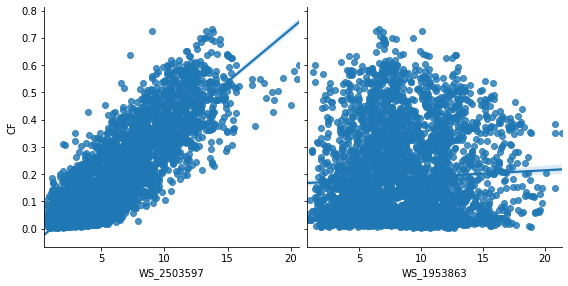

In [10]:
import seaborn as sns
sns.pairplot(df, x_vars=['WS_2503597','WS_1953863'], y_vars='CF', size=4, kind='reg')

#### You can see from the pictures how CF is changing with a high correlated fetures and a low correlated features

In [11]:
relevant_features = cor_target[cor_target > 0.51]

#### Here we picked the features that have more than 0.51 correlation. Hereinafter, we use "ALL" features, however we can generate the model just with the relevant features.

# 4- Data preprocessing

In [12]:
X = df.iloc[:, 2:-1].values
y = df.iloc[:, 1].values
y = y.reshape(len(y),1)

### 4-1 Splitting the dataset into the training and testing sets

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

### 4-2 Feature scaling
#### Here we use standard scaler feature scaler

In [14]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
y_train = sc_y.fit_transform(y_train)
X_test = sc_X.transform(X_test)

# 5- Building the SVR 

In [15]:
from sklearn.svm import SVR
SVM_R = SVR(kernel = 'rbf')

# 6- Training the SVR 

In [16]:
SVM_R.fit(X_train, y_train)

SVR()

# 7- Testing the SVR 

### 7-1 predicting on the test reults (X_test)

In [17]:
y_predict = SVM_R.predict(X_test)
y_predict = sc_y.inverse_transform(y_predict).reshape(len(y_predict),1)
# evaluate predictions
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_predict)
print('MAE: %.3f' % mae)

MAE: 0.042


### 7-2 Actual (y_test) and predicted (y_predict) test results plot

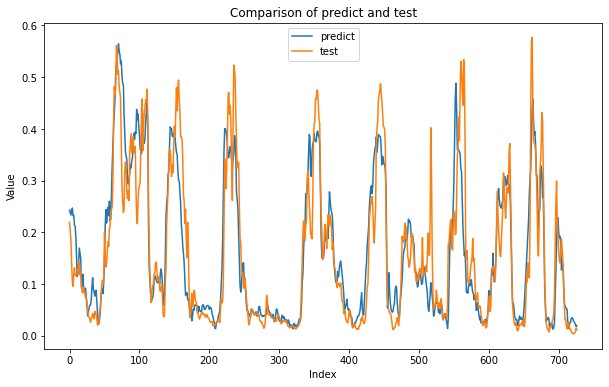

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_predict, label='predict')
plt.plot(y_test, label='test')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of predict and test')
plt.legend()

# Show the plot
plt.show()

# 8- SVR model prediction

### 8-1 Reading the new data

In [19]:
dataset2 = pd.read_csv('predict.csv')
df2 = pd. DataFrame(dataset2)
df2.head()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
0,1/9/2020 0:00,NaN,1.69,1.88,3.15,0.92,2.27,1.14,1.24,2.98,...,1.40,1.27,1.27,1.43,1.28,1.91,1.12,1.15,1.35,1.46
1,1/9/2020 1:00,NaN,1.60,2.02,3.91,0.44,2.36,1.15,1.63,2.83,...,1.02,1.11,1.43,2.04,1.60,1.57,1.03,1.28,1.49,1.29
2,1/9/2020 2:00,NaN,1.79,2.14,4.20,0.65,2.06,1.28,2.36,3.07,...,1.39,1.42,1.42,2.91,1.81,1.85,1.10,1.56,1.54,1.56
3,1/9/2020 3:00,NaN,2.01,2.32,5.17,0.51,2.31,0.83,3.39,3.38,...,1.55,2.01,1.26,2.49,2.09,2.09,1.06,2.12,1.66,2.18
4,1/9/2020 4:00,NaN,2.12,2.54,4.19,0.77,4.52,0.97,2.89,3.79,...,1.64,2.40,1.69,1.36,2.08,2.06,1.08,2.33,2.17,2.60


### 8-2 preprocessing the new data

In [20]:
X_predict = df2.iloc[:, 2:].values
X_predict = sc_X.transform(X_predict)

### 8-3 Predicting output for the new data

In [21]:
y_output = SVM_R.predict(X_predict)
y_output = sc_y.inverse_transform(y_output).reshape(len(y_output),1)

### 8-4 Exporting the output data

In [22]:
import pandas as pd
df_out = pd.DataFrame(y_output)
csv_filename = "output_SVR.csv"
df_out.to_csv(csv_filename, index=False)